In [1]:
import sys
import yaml
import numpy as np
from pathlib import Path
import hydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig
import os

sys.path.append('../')

In [2]:
from omegaconf import OmegaConf


config_dir = os.path.abspath('../conf')
with initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = compose(config_name="config")

cfg

{'data': {'signal_dim': 2, 'noise_dim': 100, 'num_actions': 4, 'traj_len': 50, 'step_size': 0.2775, 'n_train': 5000, 'n_val': 500, 'n_test': 500, 'seed': 0, 'static_noise': False, 'out_dir': 'data/'}, 'model': {'vae': {'z_dim': 2, 'enc_widths': [256, 256], 'dec_widths': [256, 256], 'activation': 'relu'}, 'contrastive': {'z_dim': 2, 'enc_widths': [256, 256], 'proj_widths': [256, 256], 'activation': 'relu'}, 'dynamics': {'dyn_widths': [256, 256], 'activation': 'relu'}, 'probe': {'probe_widths': [64, 64], 'activation': 'relu'}, 'repr': '${oc.select:model.${method}}'}, 'train': {'batch_size': 256, 'epochs_phase1': 30, 'epochs_phase2': 15, 'epochs_probe': 15, 'num_workers': 0, 'ckpt_dir': 'ckpts/', 'eval_batch_size': 512, 'wandb_log_freq': 200, 'device': 'mps', 'vae': {'lr': 0.002, 'weight_decay': 0.0, 'beta': 0.001}, 'contrastive': {'lr': 0.001, 'weight_decay': 0.0, 'temperature': 0.1}, 'dynamics': {'lr': 0.001, 'weight_decay': 0.0}, 'probe': {'lr': 0.001, 'weight_decay': 0.0}}, 'wandb': {

In [3]:
from scripts.generate_data import main as gen_main

gen_main(cfg)

train shapes: (250000, 102) (250000,) (250000, 102)
state mean/std: 0.00010768483 0.9995861
signal mean/std: -0.0005044179 0.9955477
noise mean/std: 0.00011992702 0.9996667
actions min/max/unique: 0 3 (array([0, 1, 2, 3]), array([62965, 62161, 62355, 62519]))


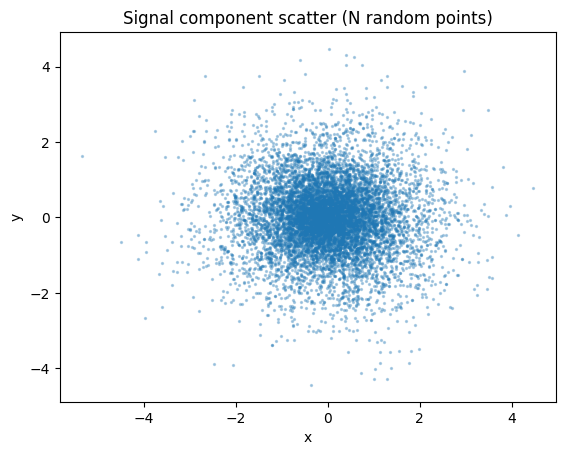

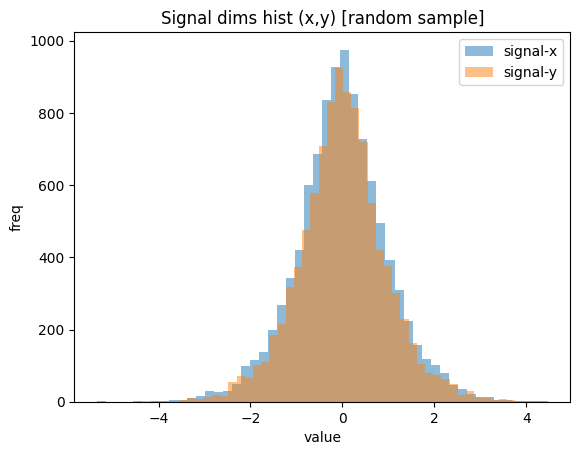

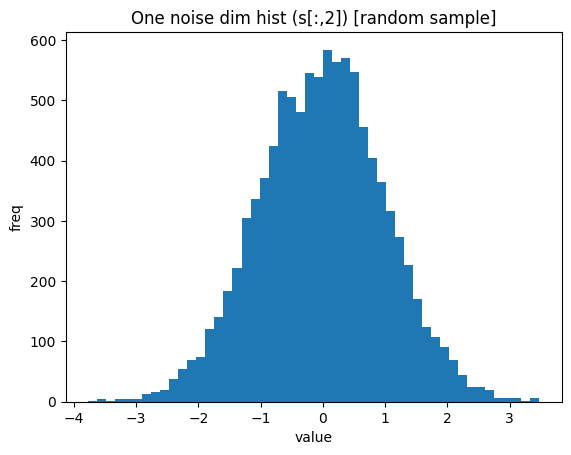

In [4]:
import matplotlib.pyplot as plt

data_dir = Path(cfg['data']['out_dir'])
train = np.load(data_dir / 'train.npz')
val = np.load(data_dir / 'val.npz')
test = np.load(data_dir / 'test.npz')

s, a, sp = train['s'], train['a'], train['sp']
print("train shapes:", s.shape, a.shape, sp.shape)

print("state mean/std:", s.mean(), s.std())
print("signal mean/std:", s[:,0:2].mean(), s[:,0:2].std())
print("noise mean/std:", s[:,2:].mean(), s[:,2:].std())
print("actions min/max/unique:", a.min(), a.max(), np.unique(a, return_counts=True))

N = min(10000, s.shape[0])
idx = np.random.choice(s.shape[0], N, replace=False)

plt.figure()
plt.scatter(s[idx,0], s[idx,1], s=2, alpha=0.3)
plt.title("Signal component scatter (N random points)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure()
plt.hist(s[idx,0], bins=50, alpha=0.5, label='signal-x')
plt.hist(s[idx,1], bins=50, alpha=0.5, label='signal-y')
plt.title("Signal dims hist (x,y) [random sample]")
plt.xlabel("value")
plt.ylabel("freq")
plt.legend()
plt.show()

plt.figure()
plt.hist(s[idx,2], bins=50)
plt.title("One noise dim hist (s[:,2]) [random sample]")
plt.xlabel("value")
plt.ylabel("freq")
plt.show()

In [5]:
# The signal has a quasi-gaussian histogram. The best non-parametric guess for reconstruction is the mean.
# MSE of that guess is the variance.

((s[:, :2] - s[:, :2].mean(axis=0))**2).mean()

np.float32(0.99108195)

In [6]:
# Same applies to the noise dimensions.
# Global MSE:

((s[:, :] - s[:, :].mean(axis=0))**2).mean()

np.float32(0.9991677)